# Сортировка мусора

## Описание проекта 

**Общая информация**

Заказчик компания Renue – IT-компания из Екатеринбурга, разрабатывает на заказ высоконагруженные и отказоустойчивые решения для крупных российских заказчиков, для бизнеса и государства. В мире, где переработка отходов играет важную роль в защите окружающей среды, сортировка мусора является ключевым элементом в повышении эффективности перерабатывающих заводов. 

**Цель проекта**

Создать модель, которая сможет распознавать различные виды отходов на основании изображений с конвейера.

**Целевая метрика** - mean average precision (mAP).

**Описание данных**

**Файлы**

- images: Папка, содержащая 9000 изображений. Каждое изображение представляет кадр с конвейерной ленты, на котором видны отходы различных типов
- train.csv: CSV-файл, содержащий разметку для обучения модели. Каждая строка включает:
    - file_name: имя файла
    - bbox: рамка в формате [x_left, y_top, width, height]
    - category_id: класс объекта, присутствующего на изображении
- test.csv: Файл, содержащий имена изображений для тестирования. Эти изображения необходимо классифицировать с помощью разработанных моделей
- sample_submission.csv: Пример файла для отправки решений:
    - file_name: имя файла
    - bbox: список списков, каждый объект в формате [class, confidence, x_left, y_top, width, height]
 
**Формат изображений:**
- 9000 изображений в формате JPEG
- Изображения представляют вид с камеры над конвейером
- Размер изображения 2048x1486 пикселей

**Классы объектов:**
Набор данных включает 15 классов пластиковых отходов:
- 1 PET (transparent) (green)
- 2 PET (transparent) (brown)
- 3 PET (transparent) (blue)
- 4 PET (transparent)
- 5 PET (transparent) (dark blue)
- 6 PET (black)
- 7 PET (white)
- 8 PET (sticker)
- 9 PET (flacon)
- 10 PET (household chemicals)
- 11 PND (household chemicals)
- 12 PND packet
- 13 Other plastic
- 14 Other plastic (transparent)
- 15 Not plastic

## Исследование существующих подходов к решению задачи

Если переводить поставленную перед нами задачу на язык машинного обучения, то эта задача представляет собой задачу детекции объектов. В отличие от задачи классификации, которая определяет класс, к которому принадлежит изображение, задача детекции использует алгоритмы машинного обучения для распознавания нескольких объектов и их расположения на изображении. Задача детекции, как правило включает в себя две подзадачи:
- классификацию объекта: определение какого типа объекты (люди, машины, животные и т.д.) находятся на изображении;
- локализацию объекта: определение того, где находятся эти изображения с прорисовкой ограничивающих рамок (bounding boxes) вокруг них.

Анализ статей в интернете показал, что для решения задачи детекции современные методы можно разделить на два типа:
- одноэтапные методы (one-stage method);
- двухэтапные методы (two-stage method).

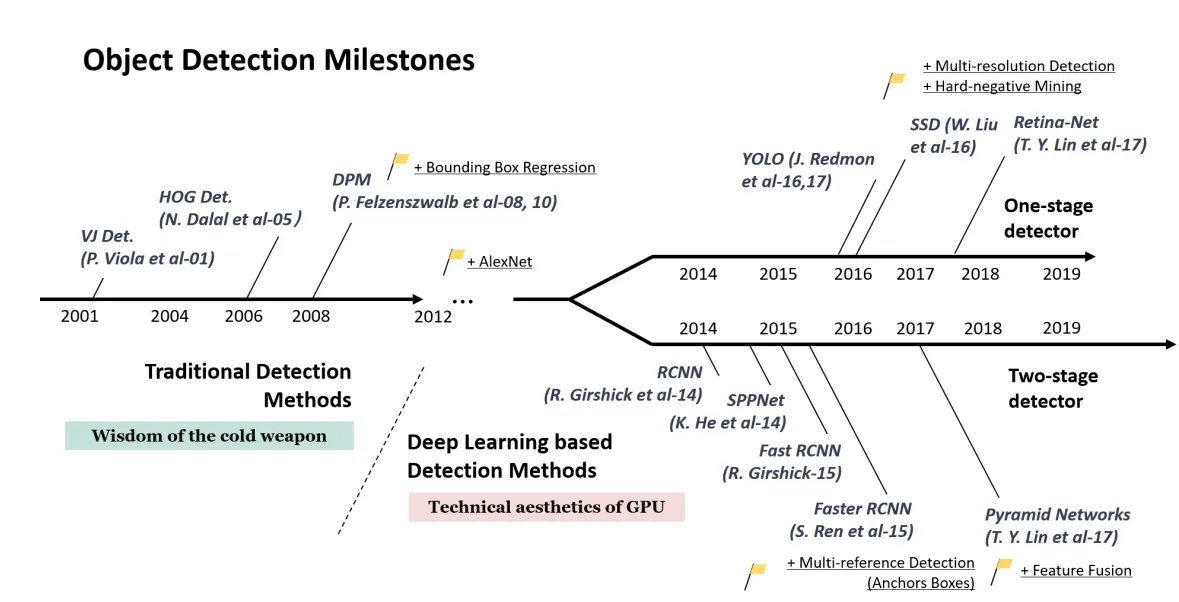

1. **Двухэтапные модели детекции** включают два этапа: генерацию регионов-кандидатов и классификацию объектов в этих регионах. Двухэтапный подход обеспечивает высокую точность, поскольку второй этап уточняет результаты, но он, как правило, медленнее из-за двухэтапного процесса. Классические двуъэтапные модели - R-CNN (Region-based Convolutional Neural Network) и ее улучшения Fast R-CNN и Faster R-CNN.        

2. **Одноэтапные модели детекции** обрабатывают входное изображение, пропуская генерацию предложений и напрямую обнаруживая объекты за один проход по изображению. Одноступенчатые детекторы обычно быстрее и лучше подходят для приложений в режиме реального времени, но они могут давать меньшую точность по сравнению с двухступенчатыми методами. Модели YOLO (You Only Look Once) и SSD (Single Shot MultiBox Detector) являются яркими примерами одноступенчатых детекторов.

Поскольку наша задача состоит в детекции объектов на конвеерной ленте мусороперерабатывающего завода, похоже, что здесь важно определять объекты в режиме реального времени. Исходя из этого, мы будем применять одноэтапные модели детекции. Одной из наиболее свежих по дате выхода моделей является модель YOLO11 от Ultralytics. Именно эту модель мы будем использовать в качестве базовой в нашем решении.

## Импорт необходимых библиотек

In [1]:
import os

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import cv2

import torch
import torchvision
from torchvision.utils import draw_bounding_boxes
from torchvision import transforms
from torchvision.ops import box_convert


In [2]:
%pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 15.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Выбор процессора
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {DEVICE} device")

Using cuda device


In [4]:
# Зададим словарь классов и меток
CLASSES = {
    'PET (transparent) (green)': 0,
    'PET (transparent) (brown)': 1,
    'PET (transparent) (blue)': 2,
    'PET (transparent)': 3,
    'PET (transparent) (dark blue)': 4,
    'PET (black)': 5,
    'PET (white)': 6,
    'PET (sticker)': 7,
    'PET (flacon)': 8,
    'PET (household chemicals)': 9,
    'PND (household chemicals)': 10,
    'PND packet': 11,
    'Other plastic': 12,
    'Other plastic (transparent)': 13,
    'Not plastic':14
}
# Также для удобства сделаем обратный словарь
idx_to_class = dict(zip(CLASSES.values(), CLASSES.keys()))

In [5]:
images_dir = '/kaggle/input/waste-detection/images'

## Импорт данных и анализ данных

Для начала ознакомимся с csv файлами, содержащими данные для тренировочной и тестовой выборок.

In [6]:
# Загрузка данных
train_data = pd.read_csv('/kaggle/input/waste-detection/train.csv')
test_data = pd.read_csv('/kaggle/input/waste-detection/test.csv')

# Вывод информации о данных
train_data.info()
print('-'*40)
test_data.info()
print('-'*40)

# Вывод первых 5 строк
display(train_data.head())
display(test_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32265 entries, 0 to 32264
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   file_name    32265 non-null  object 
 1   bbox         32148 non-null  object 
 2   category_id  32148 non-null  float64
dtypes: float64(1), object(2)
memory usage: 756.3+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  2999 non-null   object
dtypes: object(1)
memory usage: 23.6+ KB
----------------------------------------


file_name                                        bbox  category_id
0  000001.jpg                  [840.0, 0.0, 176.0, 124.0]          4.0
1  000001.jpg                [612.0, 306.0, 383.0, 397.0]          2.0
2  000001.jpg  [990.92, 551.0, 105.00000000000011, 186.0]          4.0
3  000002.jpg                [1000.0, 614.0, 98.0, 178.0]          4.0
4  000002.jpg                [605.0, 358.0, 402.0, 409.0]          2.0

file_name
0  000003.jpg
1  000006.jpg
2  000013.jpg
3  000016.jpg
4  000019.jpg

In [7]:
print('Изображений для обучения:',train_data['file_name'].nunique())
print('Изображений для теста:',test_data['file_name'].nunique())
print()
print('Уникальные классы объектов:',train_data['category_id'].sort_values().unique())
print('На изображениях для обучения нет объектов:', train_data['bbox'].isna().sum())

Изображений для обучения: 6001
Изображений для теста: 2999

Уникальные классы объектов: [          1           2           3           4           5           6           7           8           9          10          11          12          13          14          15         nan]
На изображениях для обучения нет объектов: 117


In [8]:
train_data.duplicated().sum()

0

Из технического задания нам известно, что полный датасет состоит 9 тыс. изображений. Как мы можем видеть, что из этого числа 6001 изображение отведено для обучения и 2999 изображений для тестирования.

В файле `test.csv` содержаться только названия этих 2999 изображений. 

Файл `train.csv` помимо названий содержит рамка в формате [x_left, y_top, width, height] и класс изображений. Как мы можем видеть из выгрузок выше:
- в файле содержится 32265 строк (больше чем уникальных изображений), что свидетельствует о том, на одном изображении, скорее всего может быть сразу несколько объектов;
- мы также видим (по колонкам `bbox` и `category_id`), что в данных имеются пропуски. Исходя из характера задачи, такие пропуски означают, что объектов на отдельных изображениях нет вовсе. Таких изображений 117.

Далее посмотрим, какой баланс классов наблюдается в данных для обучения.

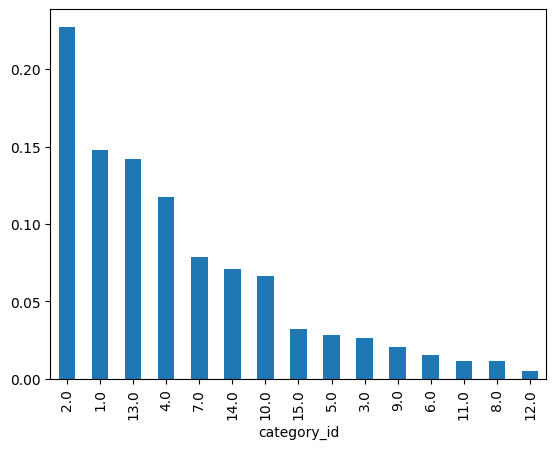

In [9]:
train_data['category_id'].value_counts(normalize=True).plot(kind='bar'); 

Мы можем видеть, что среди объектов в выборке для обучения наблюдается дисбаланс классов. Больше всего объектов класса 2 PET (transparent) (brown), также в датасете много отходов классов 1 PET (transparent) (green), 13 Other plastic, 4 PET (transparent), 7 PET (white), 14 Other plastic (transparent) и 10 PET (household chemicals). Остальных классов в датасете намного меньше.
Исходя из вышесказанного, нас необходимо учитывать наличие дисбаланса классов при обучении модели. Одним из способов борьбы с дисбалансом классов в задаче детекции является применение агументаций. Аугментации применим сразу на этапе обучения модели.

После изучения возможных архитектур, которые подходят для решения нашей задачи,в качестве базовой архитектуры мы выбрали YOLO от Ultralytics. Модели этой архитектуры требуют подготовки данных в определенном формате, а именно раскладываение датасета в строго определенной структуре и наличие файла с настройками в формате yaml. 

Мы сформировали датасет и файл с настройками для обучения модели YOLO с помощью отдельной тетрадки (см. garbage_detection/99_garbage-detection-data.ipynb), чтобы не проходить этот этап каждый раз. Изображения из выборки для обучения мы разделили на тренировочный и валидационный датасет, выделив в тренировочную выборку 0.75 от изображений из файла `train.csv`. В тестовую выборку мы скопирововали все изображения из файла `test.csv`. В итоге мы получили датасет со следующей структурой:
```
yolo_dataset/
├── images/
│   ├── train/
│   ├── val/
│   ├── test/
├── labels/
│   ├── train
│   ├── val/
data.yaml
```

После разделения датасета на тренировочную, валидационную и тестовую выборки число изображений в каждой из выборок составило:
- train - 4500 изображений;
- val - 1501 изображений;
- test - 2999 изображений.

Посмотрим, каким образом выглядят изображения в нашем датасете.

In [10]:
# Функция для визуализации изображения с bounding boxes
def visualize_sample(image_path, label_path):
    # Читаем изображение
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Читаем аннотацию (YOLO формат: class x_center y_center width height)
    with open(label_path, 'r') as f:
        labels = f.readlines()

    # Парсим каждую строку
    for label in labels:
        cls, x_center, y_center, width, height = map(float, label.split())
        cls = int(cls)  # Класс объекта

        # Конвертируем координаты из YOLO формата в (x_min, y_min, x_max, y_max)
        h, w, _ = image.shape
        x_min = int((x_center - width / 2) * w)
        y_min = int((y_center - height / 2) * h)
        x_max = int((x_center + width / 2) * w)
        y_max = int((y_center + height / 2) * h)

        # Рисуем bounding box и метку
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=2)
        cv2.putText(image, f'Class: {cls}, label: {idx_to_class[cls]}', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (255, 0, 0), 2)

    # Визуализация
    plt.imshow(image)
    plt.axis('off')

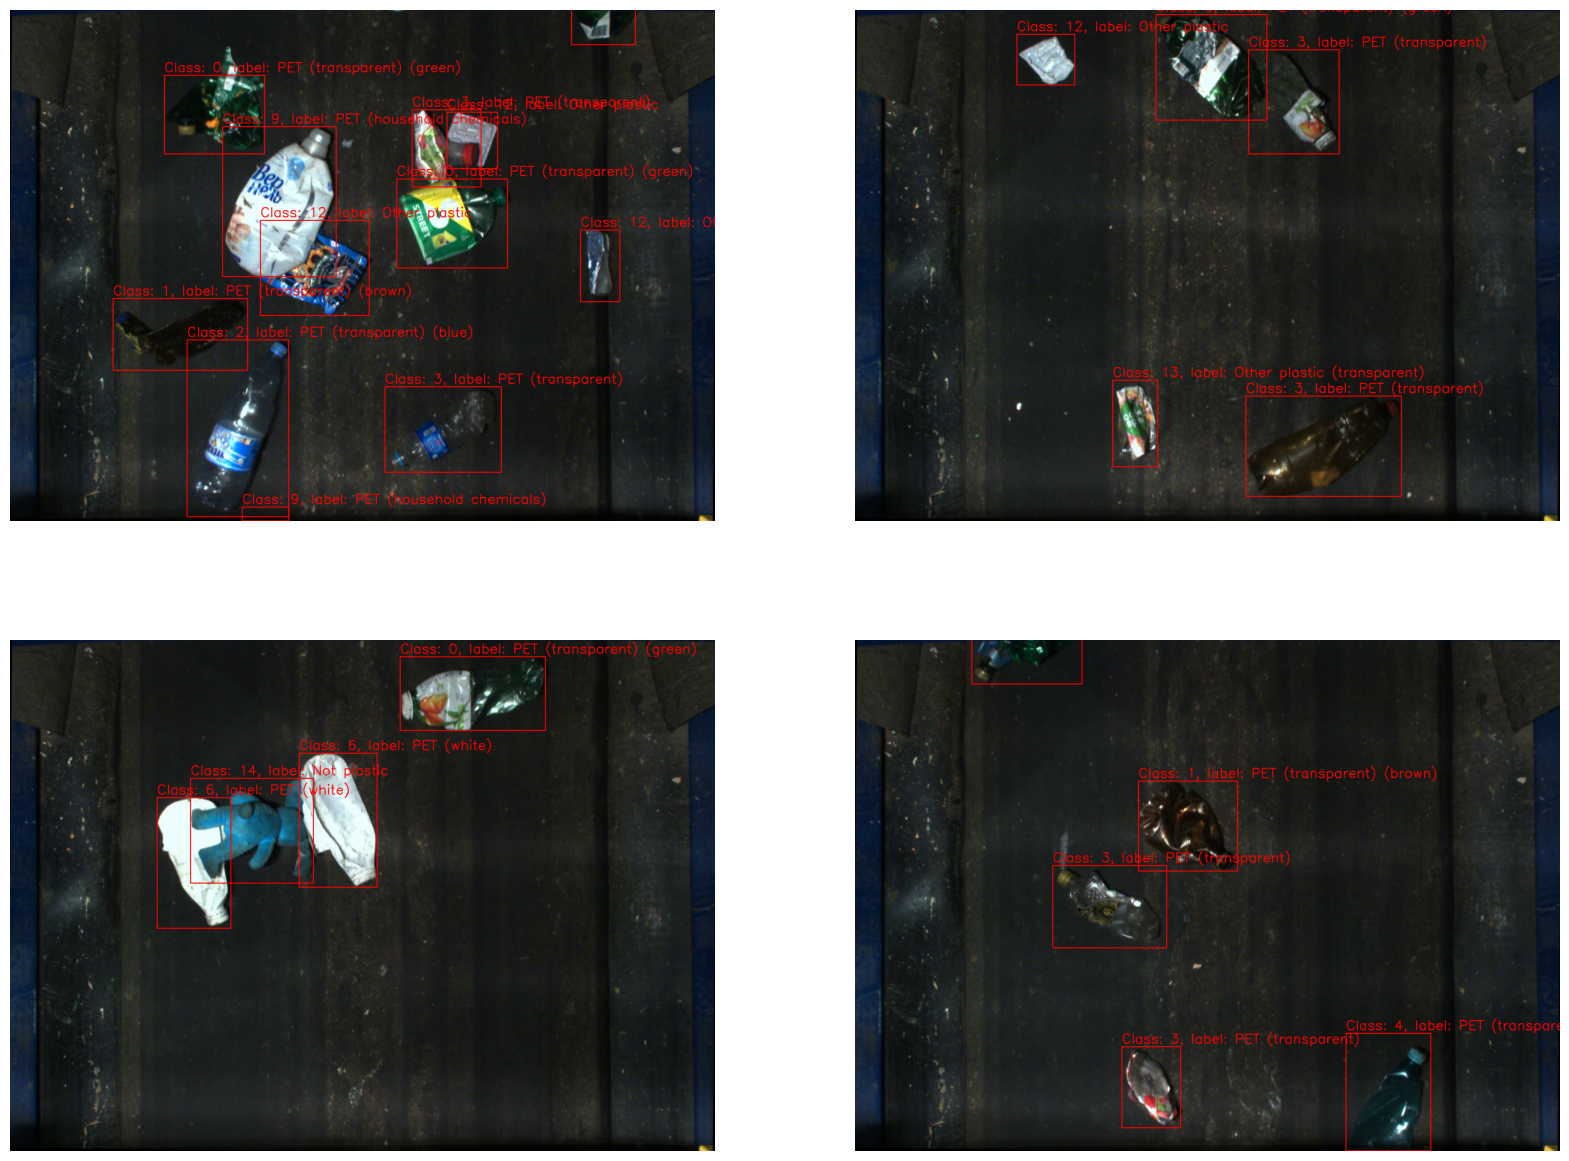

In [11]:
# Зададим переменные с путями к изображениям и меткам трейна
train_img_path = '/kaggle/input/garbage-detection-data/yolo_dataset/images/train/'
train_label_path = '/kaggle/input/garbage-detection-data/yolo_dataset/labels/train/'
train_file_names = []
# Сохраним названия изображений трейна в переменую
for dirname, _, filenames in os.walk(train_img_path):
    for filename in filenames:
        train_file_names.append(filename)
        
# Выберем рандомные 4 изображения и визуализируем их и разметку 
idx = np.random.randint(0, len(train_file_names), 4)
fig = plt.figure(figsize=(20,15))

for i in range(len(idx)):
    fig.add_subplot(2, 2, i+1)
    data = train_file_names[idx[i]]
    image_path = os.path.join(train_img_path,data)
    label_path = os.path.join(train_label_path, (os.path.splitext(data)[0]+'.txt'))
    visualize_sample(image_path, label_path)
plt.show();

Мы можем видеть, что в датасете цветные изображения, представляющие собой фотографии конвеерной ленты. На фотографиях мы можем видеть различные отходы, по разному расположенные (разбросаны по отдельности/лежат скученно/объектов нет вовсе и т.п.).

## Обучение моделей

**Выбор модели**

Для задачи детекции внутри YOLO11 предусмотрены сразу несколько видов моделей (характеристики в таблице ниже).

|Model| size (pixels)|mAPval 50-95 | Speed CPU ONNX (ms) | Speed T4 TensorRT10 (ms) |params (M) |FLOPs (B)|
|------- | --- | ----- |-------- |-------- | --- | ---|
|YOLO11n|640|39.5|56.1 ± 0.8|1.5 ± 0.0|2.6|6.5|
|YOLO11s|640|47.0|90.0 ± 1.2|2.5 ± 0.0|9.4|21.5|
|YOLO11m|640|51.5|183.2 ± 2.0|4.7 ± 0.1|20.1|68.0|
|YOLO11l|640|53.4|238.6 ± 1.4|6.2 ± 0.1|25.3|86.9|
|YOLO11x|640|54.7|462.8 ± 6.7|11.3 ± 0.2|56.9|194.9|

Среди указанных моделей мы попробовали предобученные версии YOLO11s, YOLO11m и YOLO11l. Мы начали с модели YOLO11m и она дала наилучшие результаты по целевой метрике. Применение YOLO11s чуть снизило показатели метрик, видимо здесь сыграло меньшее число параметров. По числу параметров YOLO11m значительно превышает YOLO11s (20.1 против 9.4 M). А вот переход от YOLO11m к YOLO11l не дал нам ожидаемого улучшения качества, скорее всего из-за того, что число параметров не отличается от YOLO11m на порядок так, как это было при переходе от YOLO11s к YOLO11m. Модель YOLO11x не тестировалась из-за ограничения по GPU на платформе Kaggle.

В каждой из опробованных версий моделей мы заменяли число классов на последнем слое на нужные нам 15 (эту настройку прописывали в конфигурации к датасету в формате yaml). Мы также пробовали применить заморзку 10 первых слоев (backbone) моделей, однако заморозка слоев не дала улучшения качества по сравнению с моделяи без заморозки.

**Предобработка изображений**

Как мы уже отмечали выше, мы приняли решение применять аугментации к датасету для увеличения выборки и снижения эффекта от имеющегося дисбаланса классов. Согласно документации YOLO11 модель предусматривает применение аугментаций сразу внутри модели YOLO. Опытным путем было выявлено, что во все версии моделей выше зашит одинаковый набор аугментаций "по умолчанию":
- hsv_h=0.015 (hue of image),
- hsv_s=0.7 (saturation of image),
- hsv_v=0.4 (brightness),
- degrees=0.0 (random rotation of image),
- translate=0.1 (translates the image horizontally and vertically by a fraction of the image size),
- scale=0.5 (scales the image by a gain factor),
- shear=0.0 (shears the image by a specified degree),
- perspective=0.0 (applies a random perspective transformation),
- flipud=0.0 (flips the image upside down with the specified probability),
- fliplr=0.5 (Flips the image left to right with the specified probability), 
- bgr=0.0 (flips the image channels from RGB to BGR), 
- mosaic=1.0 (combines four training images into one), 
- mixup=0.0 (blends two images and their labels, creating a composite image), 
- copy_paste=0.0 (copies objects from one image and pastes them onto another), 
- copy_paste_mode=flip (Copy-Paste augmentation method selection among the options of ("flip", "mixup"), 
- auto_augment=randaugment (Automatically applies a predefined augmentation policy (randaugment, autoaugment, augmix), 
- erasing=0.4 (Randomly erases a portion of the image during classification training, encouraging the model to focus on less obvious features for recognition) , 
- crop_fraction=1.0 (Crops the classification image to a fraction of its size to emphasize central features and adapt to object scales, reducing background distractions).


В виду ограниченного времени и того факта, что данный набор включал в себя интересные с нашей точки зрения аугментации, мы не меняли этот набор агументаций при тестировании различных моделей.

**Выбор алгоритмов и гиперпараметров**
- В качестве оптимизатора мы решили выбрать оптимизатор Adam.
- Начальную скорось обучения lr0 мы установили в размере 3e-4. Это значение зачастую используют в процессе обучения при начале работы с реальными данными.
- Из-за ограничений памяти размер батча для обучения и валидации мы установили как -1. Согласно документации к модели, такой размер батча позволяет автоматически использовать  60% памяти GPU.
- Количество эпох обучения: мы пробовали обучать модели на 50 и 100 эпохах с указанием параметра patience=5. Этот параметр останавливает обучение после n-го количества эпох без улучшения качества модели.


В качестве базовой архитектуры нами была выбрана архитектура YOLO. Инициализируем модель и пропишем вышеуказанные настройки (ниже указаны настройки для модели, которая дала наилучшее качество из сданных решений).

In [12]:
model = YOLO("yolo11m.pt") 

100%|██████████| 38.8M/38.8M [00:00<00:00, 253MB/s]


In [13]:
results = model.train(data='/kaggle/input/garbage-detection-data/data.yaml', 
                      epochs=50,
                      batch=-1,
                      imgsz=640,
                      patience=8,
                      val=True,
                      name='garbage_detection',
                      device='cuda',
                      save=True,
                      optimizer='Adam',
                      lr0=3e-4)

Ultralytics 8.3.39 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/kaggle/input/garbage-detection-data/data.yaml, epochs=50, time=None, patience=8, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=garbage_detection, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh

100%|██████████| 755k/755k [00:00<00:00, 17.7MB/s]
2024-12-01 09:39:20,530	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-01 09:39:21,173	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.4MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/garbage-detection-data/yolo_dataset/labels/train... 4500 images, 94 backgrounds, 0 corrupt: 100%|██████████| 4500/4500 [00:17<00:00, 261.07it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/garbage-detection-data/yolo_dataset/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.74G total, 0.21G reserved, 0.19G allocated, 14.33G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    20064573       68.25         0.799          59.2         156.4        (1, 3, 640, 640)                    list
    20064573       136.5         1.300            42         68.94        (2, 3, 640, 640)                    list
    20064573         273         2.305         63.52          87.5        (4, 3, 640, 640)                    list
    20064573         546  

train: Scanning /kaggle/input/garbage-detection-data/yolo_dataset/labels/train... 4500 images, 94 backgrounds, 0 corrupt: 100%|██████████| 4500/4500 [00:05<00:00, 801.07it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/garbage-detection-data/yolo_dataset/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/garbage-detection-data/yolo_dataset/labels/val... 1501 images, 23 backgrounds, 0 corrupt: 100%|██████████| 1501/1501 [00:05<00:00, 258.96it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/garbage-detection-data/yolo_dataset/labels is not writeable, cache not saved.
Plotting labels to runs/detect/garbage_detection/labels.jpg... 
optimizer: Adam(lr=0.0003, momentum=0.937) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/garbage_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      8.81G     0.8265      1.391      1.018         53        640: 100%|██████████| 282/282 [02:57<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.15it/s]

                   all       1501       7875      0.547      0.549       0.55      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.81G     0.7646     0.9078     0.9906         36        640: 100%|██████████| 282/282 [03:13<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


                   all       1501       7875      0.734      0.721      0.764      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.63G     0.7418      0.789     0.9825         23        640: 100%|██████████| 282/282 [03:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.26it/s]

                   all       1501       7875      0.726      0.721      0.778      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.77G     0.7352     0.7281     0.9802         57        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.24it/s]

                   all       1501       7875      0.846      0.757      0.849      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.76G      0.716      0.663     0.9701         31        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1501       7875      0.877       0.81      0.892      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       8.8G      0.697     0.6165     0.9637         41        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1501       7875      0.908       0.82      0.897       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.69G     0.6825     0.5781     0.9586         32        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.26it/s]

                   all       1501       7875      0.919       0.85       0.92      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       8.8G     0.6746     0.5563     0.9537         48        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.26it/s]

                   all       1501       7875      0.925      0.837      0.922      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.68G     0.6673     0.5351     0.9522         18        640: 100%|██████████| 282/282 [03:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.26it/s]

                   all       1501       7875      0.925       0.86      0.921      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.78G     0.6581     0.5159     0.9458         40        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1501       7875      0.942      0.873      0.933      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       8.7G      0.646     0.5055     0.9442         14        640: 100%|██████████| 282/282 [03:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1501       7875      0.967      0.877      0.937      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.84G     0.6368     0.4795     0.9407         51        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.24it/s]

                   all       1501       7875      0.944      0.878       0.94      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.75G      0.627     0.4698     0.9348         27        640: 100%|██████████| 282/282 [03:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.24it/s]

                   all       1501       7875      0.955      0.871      0.937      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.71G     0.6197     0.4604     0.9356         56        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.26it/s]

                   all       1501       7875      0.965      0.882      0.942      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.79G     0.6066     0.4514     0.9307         60        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.24it/s]

                   all       1501       7875      0.958      0.889      0.944      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       8.8G     0.6079     0.4429     0.9308         31        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1501       7875      0.971      0.893      0.947      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.79G     0.6005     0.4309     0.9262         50        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.27it/s]

                   all       1501       7875      0.967      0.893      0.946      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.77G     0.5917     0.4293     0.9258         50        640: 100%|██████████| 282/282 [03:12<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1501       7875      0.966      0.901      0.947      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.77G     0.5915       0.42     0.9251         41        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.24it/s]

                   all       1501       7875      0.972      0.895      0.949      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.68G     0.5816     0.4111     0.9231         36        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.23it/s]

                   all       1501       7875      0.971      0.903      0.952      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       8.7G     0.5797     0.4064      0.924         42        640: 100%|██████████| 282/282 [03:12<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.24it/s]

                   all       1501       7875      0.977      0.895       0.95      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.81G      0.574     0.3972     0.9195         42        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1501       7875      0.977      0.906      0.953      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.69G     0.5611     0.3926     0.9154         33        640: 100%|██████████| 282/282 [03:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.20it/s]

                   all       1501       7875      0.979      0.897      0.953      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.84G     0.5556     0.3864     0.9139         25        640: 100%|██████████| 282/282 [03:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1501       7875      0.977        0.9      0.953       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.68G     0.5575     0.3857     0.9126         29        640: 100%|██████████| 282/282 [03:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.26it/s]

                   all       1501       7875      0.979      0.898      0.951      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       8.8G     0.5467     0.3758     0.9077         23        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1501       7875      0.979      0.906      0.953      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.69G     0.5444     0.3698     0.9071         43        640: 100%|██████████| 282/282 [03:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.26it/s]

                   all       1501       7875      0.979        0.9      0.953      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.81G     0.5396     0.3659     0.9078         36        640: 100%|██████████| 282/282 [03:12<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.26it/s]

                   all       1501       7875      0.978      0.909      0.956      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.68G     0.5345     0.3613     0.9031         27        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.28it/s]

                   all       1501       7875       0.98      0.906      0.954      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.79G     0.5282     0.3534     0.9041         18        640: 100%|██████████| 282/282 [03:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.24it/s]

                   all       1501       7875      0.982      0.904      0.956      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.72G     0.5273     0.3525      0.904         34        640: 100%|██████████| 282/282 [03:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.28it/s]

                   all       1501       7875      0.979       0.91      0.956      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.85G     0.5211     0.3481     0.9007         50        640: 100%|██████████| 282/282 [03:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1501       7875      0.985      0.908      0.957      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.81G     0.5196     0.3414     0.9001         43        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.27it/s]

                   all       1501       7875      0.984      0.915      0.958       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       8.8G     0.5131     0.3428     0.8995         62        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.23it/s]

                   all       1501       7875      0.981      0.907      0.956      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.68G     0.5064     0.3353      0.897         27        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1501       7875      0.977      0.919      0.958       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.79G     0.5035      0.327     0.8942         38        640: 100%|██████████| 282/282 [03:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.22it/s]

                   all       1501       7875       0.98      0.912      0.958      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       8.8G     0.4984     0.3301     0.8944         46        640: 100%|██████████| 282/282 [03:12<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1501       7875      0.984      0.913      0.959      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.81G     0.4903     0.3158     0.8916         28        640: 100%|██████████| 282/282 [03:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.24it/s]

                   all       1501       7875      0.979      0.922      0.959      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.79G     0.4849     0.3148     0.8881         33        640: 100%|██████████| 282/282 [03:11<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.27it/s]

                   all       1501       7875      0.982      0.914      0.959      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.71G     0.4833      0.315     0.8892         32        640: 100%|██████████| 282/282 [03:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.28it/s]

                   all       1501       7875      0.979      0.921       0.96       0.87


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.78G     0.4254      0.262     0.8554         22        640: 100%|██████████| 282/282 [03:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.24it/s]

                   all       1501       7875      0.981      0.918      0.957      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.84G     0.4171     0.2565     0.8502         18        640: 100%|██████████| 282/282 [03:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.24it/s]

                   all       1501       7875      0.981      0.918      0.958      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.81G     0.4113     0.2502     0.8501         25        640: 100%|██████████| 282/282 [03:09<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.24it/s]

                   all       1501       7875      0.979      0.917      0.959      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.82G     0.4056     0.2484     0.8477         32        640: 100%|██████████| 282/282 [03:09<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.23it/s]

                   all       1501       7875      0.984      0.914      0.958       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.79G     0.3969     0.2411     0.8448          9        640: 100%|██████████| 282/282 [03:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.27it/s]

                   all       1501       7875      0.986      0.915      0.959      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.82G     0.3956     0.2408     0.8463         20        640: 100%|██████████| 282/282 [03:09<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.26it/s]

                   all       1501       7875      0.981      0.919      0.959      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.78G     0.3864     0.2349     0.8401         20        640: 100%|██████████| 282/282 [03:09<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.24it/s]

                   all       1501       7875      0.982      0.919      0.959      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.85G     0.3828     0.2336     0.8402         11        640: 100%|██████████| 282/282 [03:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.26it/s]

                   all       1501       7875      0.981      0.922      0.959      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.79G     0.3791     0.2304     0.8393         23        640: 100%|██████████| 282/282 [03:09<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:20<00:00,  2.25it/s]

                   all       1501       7875      0.982       0.92      0.959      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.82G     0.3752     0.2285     0.8379         16        640: 100%|██████████| 282/282 [03:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:21<00:00,  2.23it/s]

                   all       1501       7875      0.984      0.915      0.959      0.875



50 epochs completed in 2.971 hours.
Optimizer stripped from runs/detect/garbage_detection/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/garbage_detection/weights/best.pt, 40.5MB

Validating runs/detect/garbage_detection/weights/best.pt...
Ultralytics 8.3.39 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 303 layers, 20,041,597 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:22<00:00,  2.09it/s]


                   all       1501       7875      0.981      0.922      0.959      0.876
PET (transparent) (green)        843       1172      0.986      0.952      0.978      0.896
PET (transparent) (brown)        969       1739       0.99      0.941       0.97      0.894
PET (transparent) (blue)        193        202      0.982      0.926      0.969      0.885
     PET (transparent)        674        918      0.978      0.926      0.967      0.866
PET (transparent) (dark blue)        224        244      0.975      0.941      0.974      0.898
           PET (black)        109        115      0.981      0.913      0.953      0.879
           PET (white)        520        637      0.985      0.929      0.964      0.887
         PET (sticker)         69         75      0.971      0.947      0.957       0.86
          PET (flacon)        156        174      0.974      0.865      0.941      0.847
PET (household chemicals)        436        541      0.978      0.907      0.952       0.89
PND

Мы обучили модель на 50 эпохах и можем сказать следующее про качество модели на валидации:
- точность Precision (P в таблице выше) по всем классам соcтавила 0.981. Precision показывает, сколько обнаружений было правильным.
- полнота Recall (R в таблице выше) по всем классам составила 0.922. Эта метрика отражает способность модели идентифицировать все экземпляры объектов на изображениях.
- по метрике mAP@0.50:0.95  для всех классов составило 0.876. Эта метрика оценивает среднюю точность, рассчитанную при различных пороговых значениях IoU, варьирующихся от 0,50 до 0,95.

Посмотрим на графики функций потерь определения классов и ограничительных рамок, которые получились в результате обучения и валидации нашей модели.
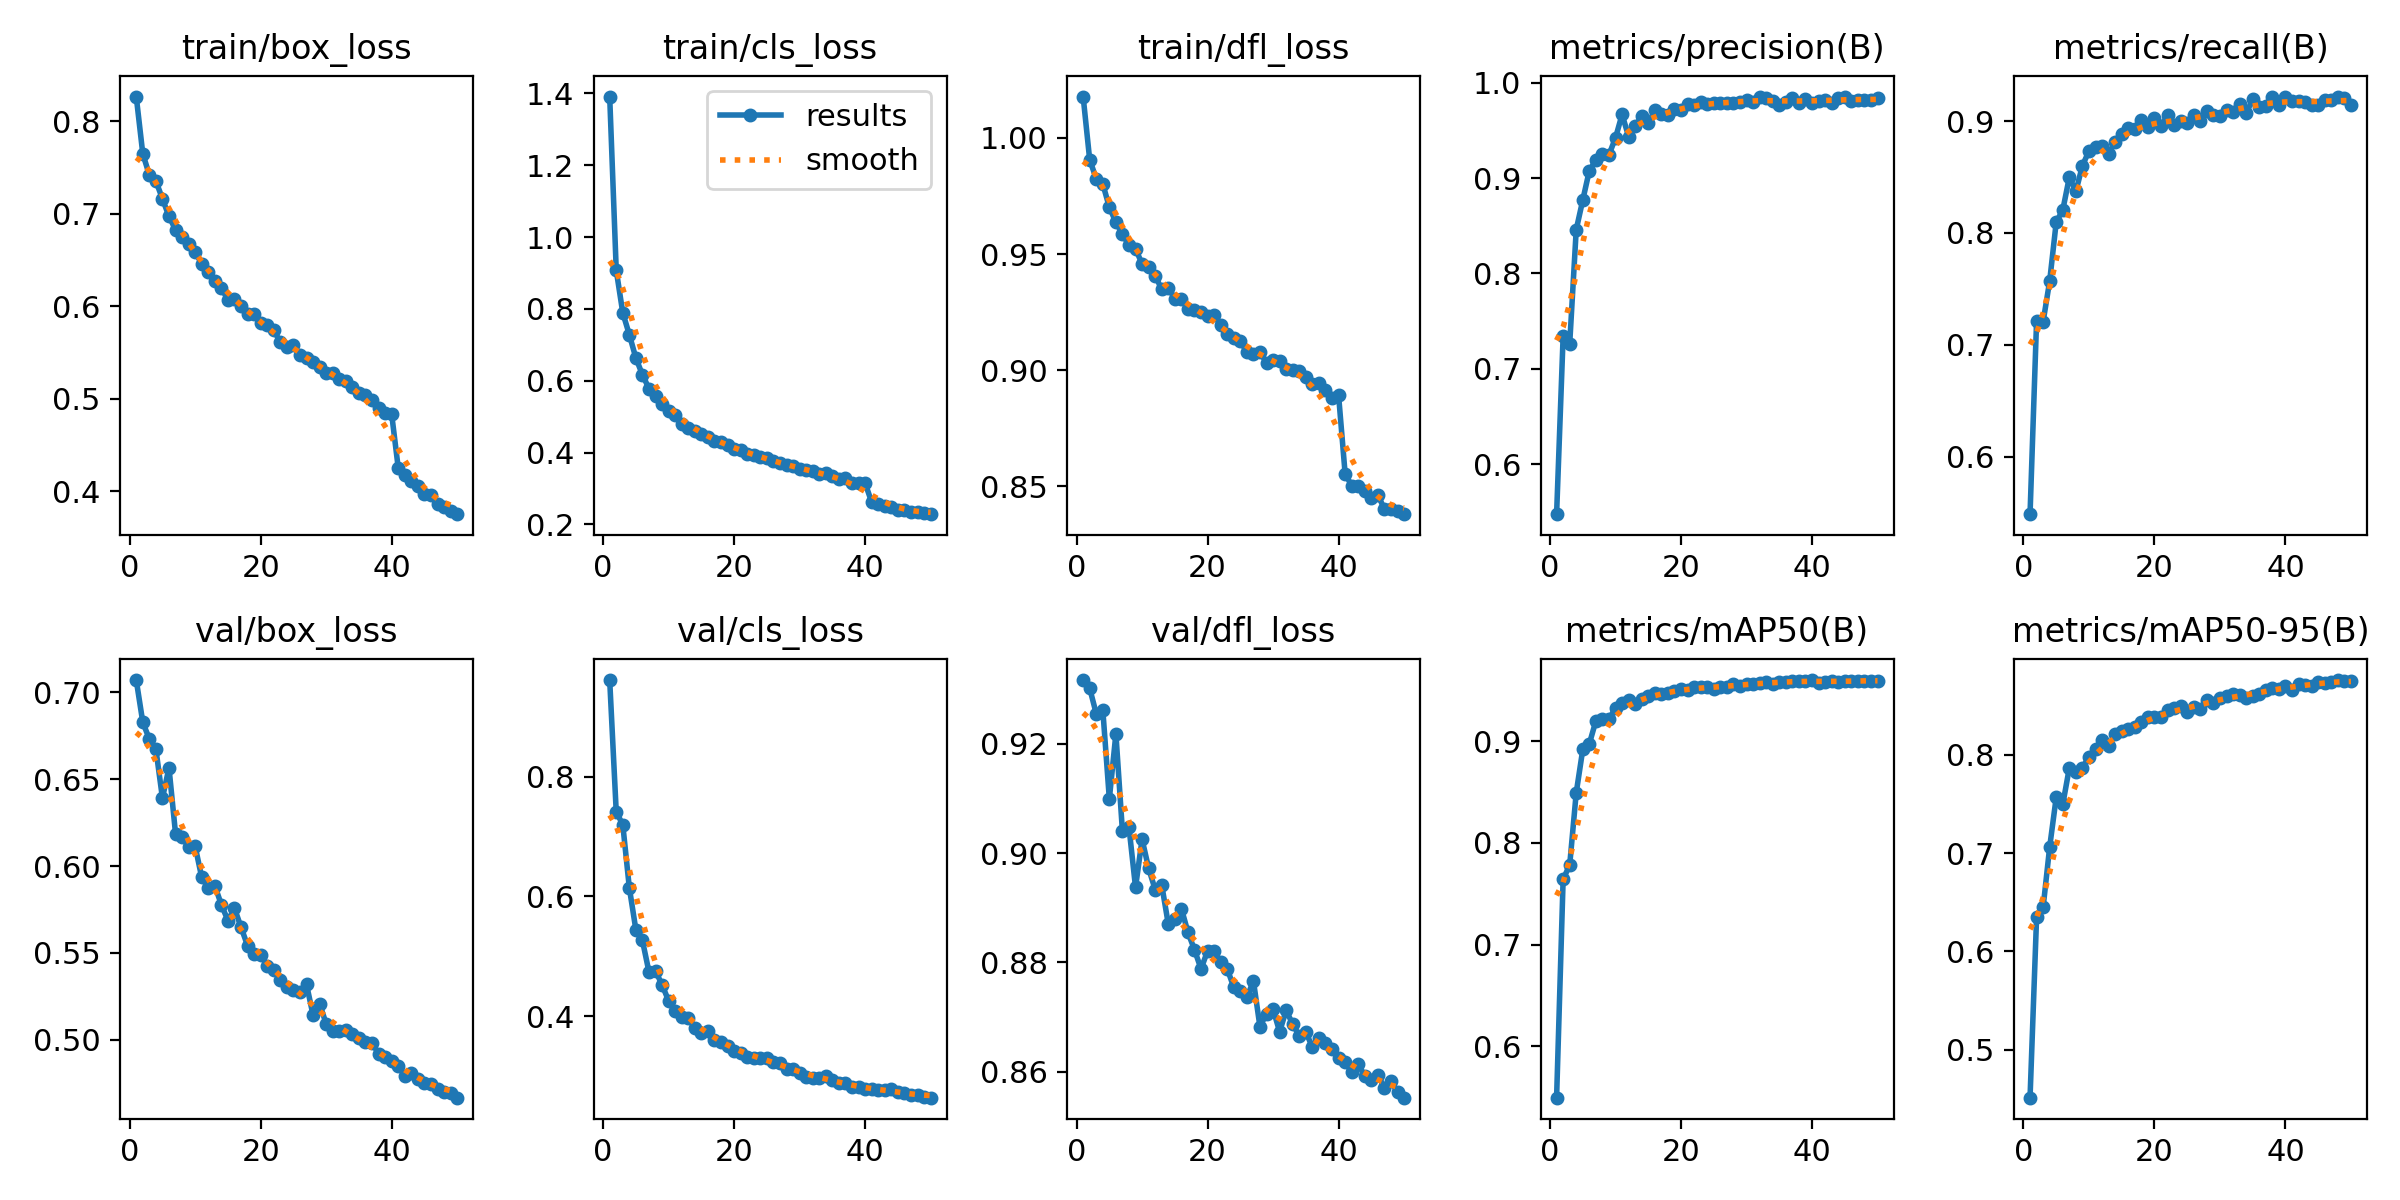

Из графиков, которые модель выводит автоматически в качестве аутпута, мы можем сказать следующее:
- Мы можем видеть хорошее стабильное снижение функции потерь определения классов как на обучении, так и на валидации. 
- Функция потерь определения ограничивающих рамок на обучении до 40 эпохи снижалась постепено, затем произошло резкое снижение. Предлполагаем, что это связано с тем, что за 10 эпох до окочания обучения согласно настройкам аугментации, в модели при обучении перестали подаваться батчи с аугментацией по типу mosaic, когда несколько изображений собираются в одно. На валидации подобной картины не наблюдалось, снижение происходило плавно.
- Мы видим, что график целевой метрики mAP довольно быстро (до 20 эпохи) достиг высоких значений (выше 0.8) затем прирастал очень медленно к 50-й эпохе.

Посмотрим отдельно на матрицу ошибок полученной нами модели.

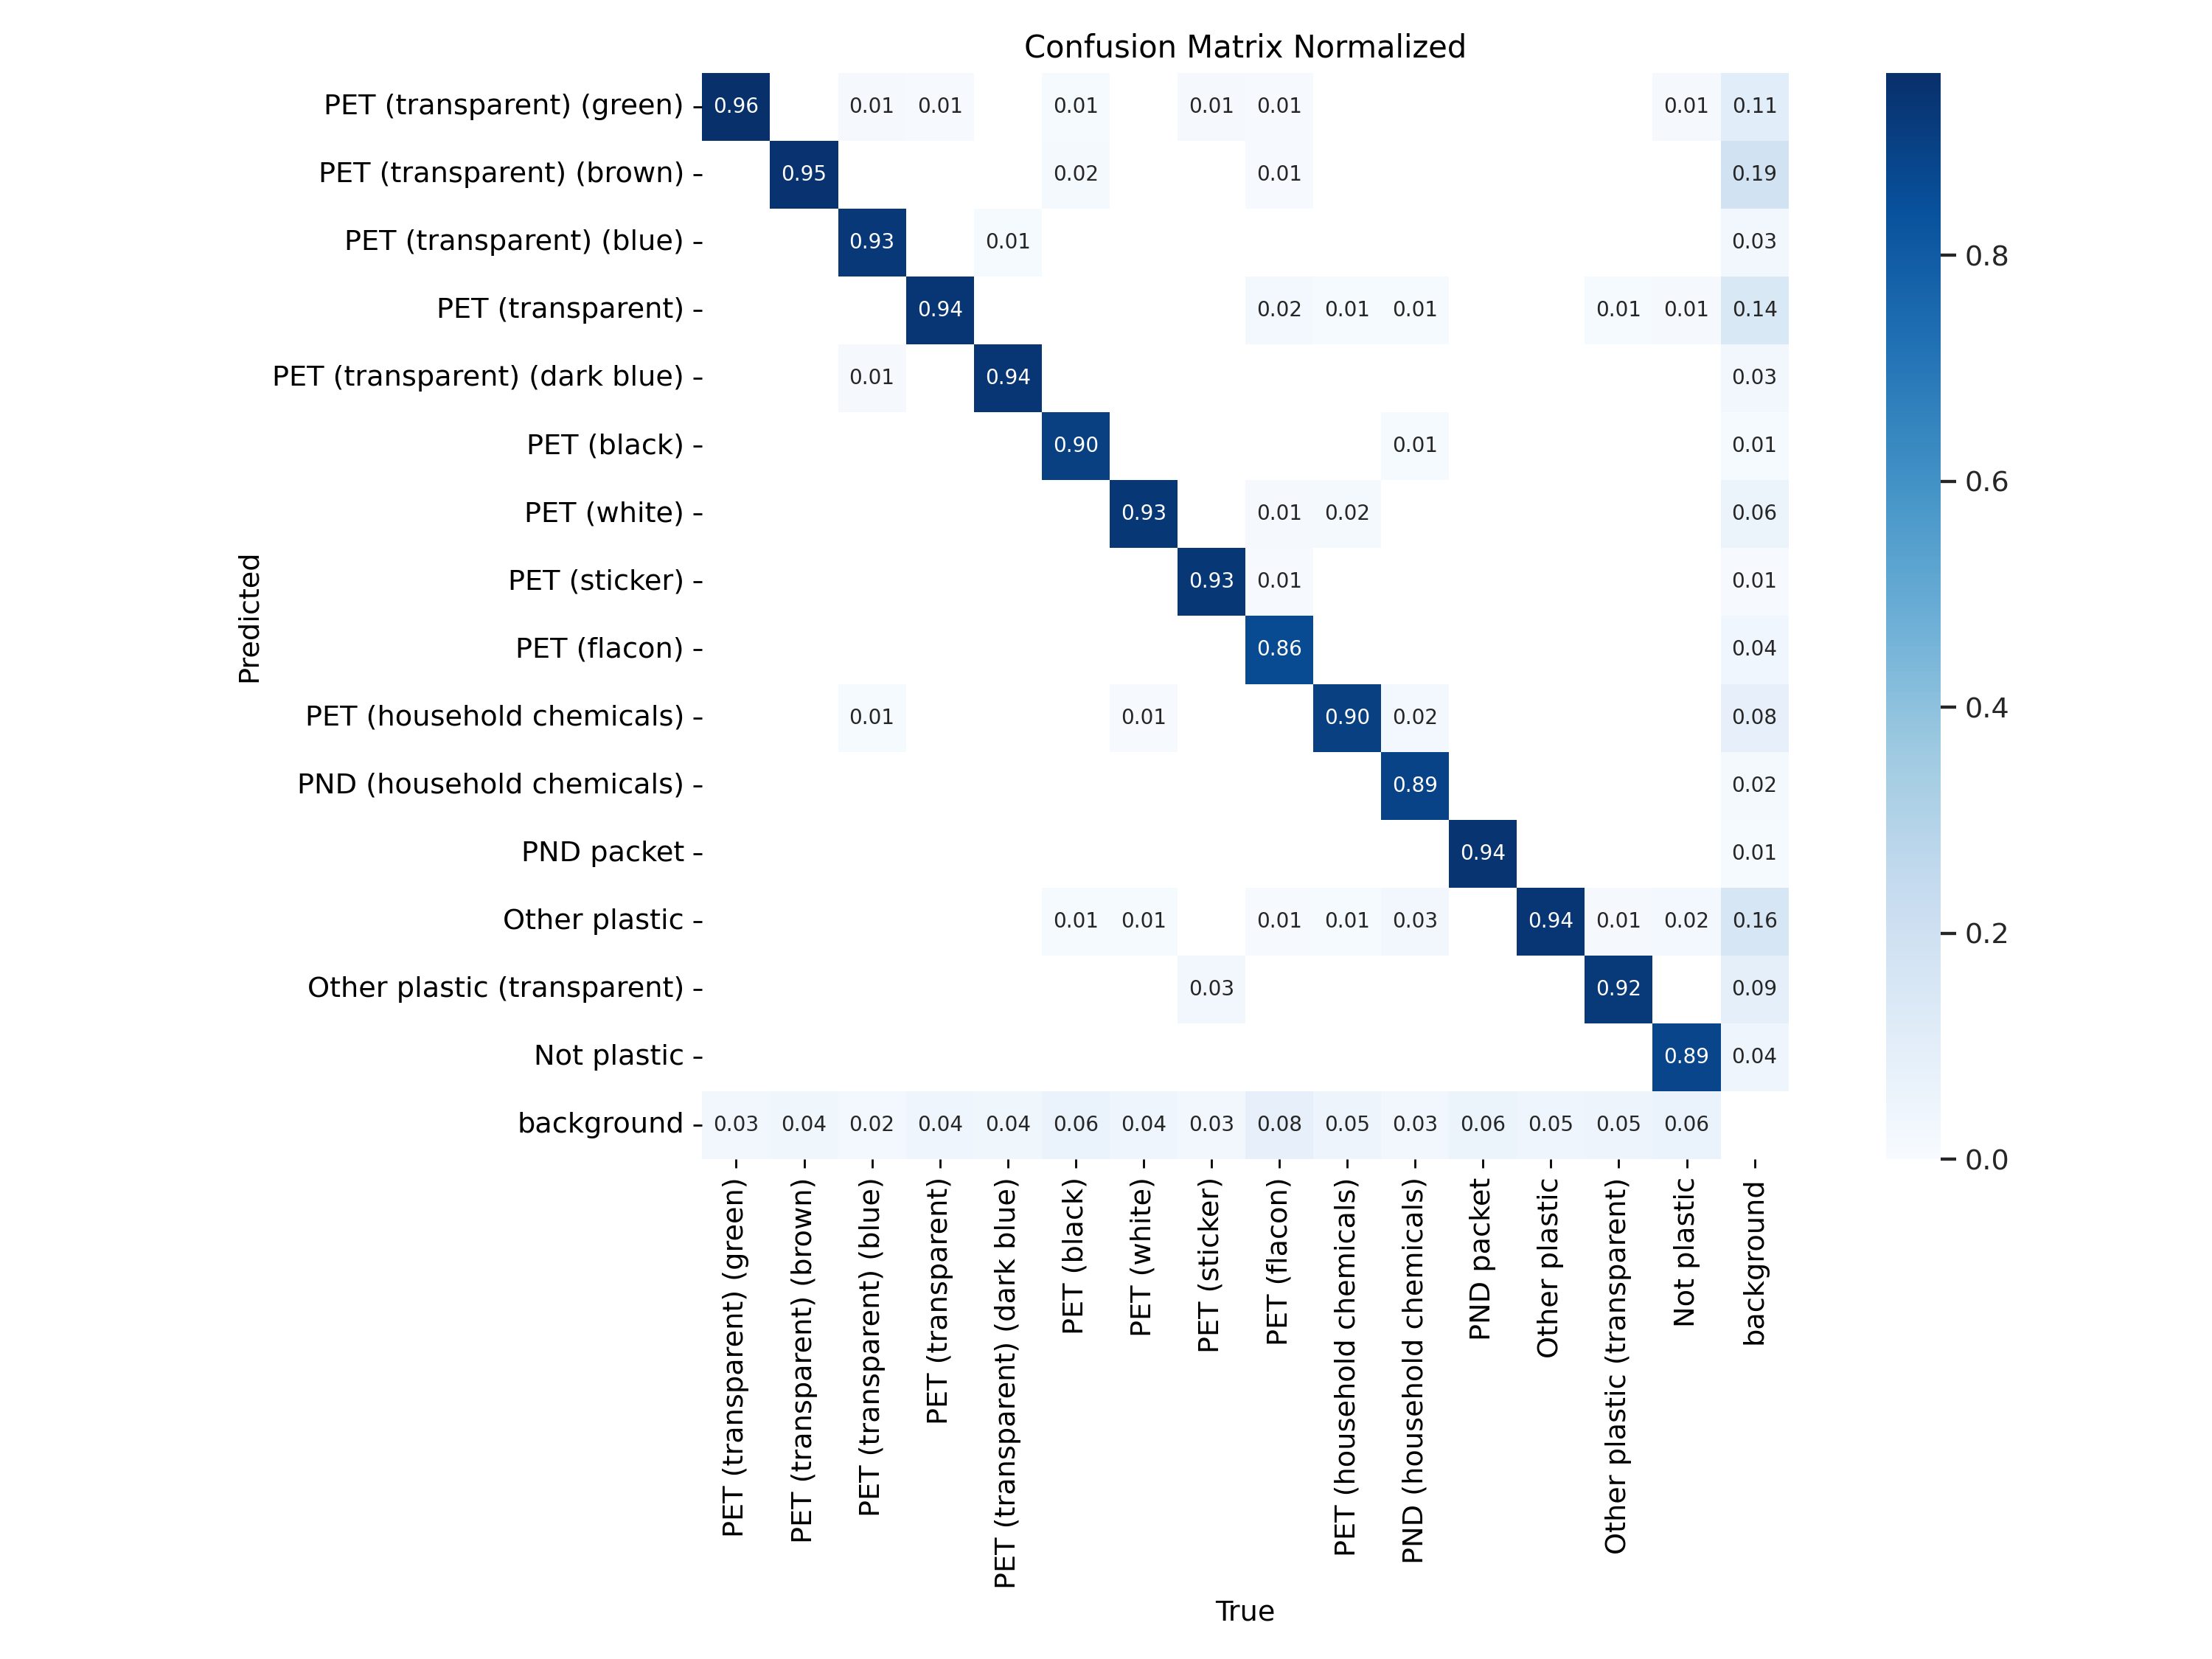



Как мы можем видеть из матрицы ошибок выше:
- модель достаточно хорошо правильно определяет объекты всех классов. Для каждого класса модель правильно детектирует объекты в более чем 86% случаев:
    - в 86% случаев - для класса PET (flacon);
    - 89%  - для классов PND (household chemicals) и Not plastic;
    - 90% - PET (black), PET (household chemicals);
    - 92% - для класса Other plastic (transparent);
    - 93% - для классов PET (transparent) (blue),PET (white), PET (sticker);
    - 94%  - для классов PET (transparent), PET (transparent) (dark blue), PND packet, Other plastic;
    - 95% - PET (transparent) (brown);
    - 96% - PET (transparent) (green).
- попадаются небольшое количество случаев, когда модель ошибочно определяет объекты одного класса, как объекты другого класса, например:
    - объекты класса для классов PET (transparent) (blue) в 1% случаев ошибочно распознаются как  PET (transparent) (green), в 1% случаев - как PET (transparent) (dark blue), в 1% случаев - как PET (household chemicals), в 2% случаев - они ошибочно распознаются как background, что мы предполагаем значит, что объект не был детектирован и модель решила, что это что-то фоновое; или
    - объекты класса PET (sticker) в 1% cлучаев ошибочно распознаются как  PET (transparent) (green), в 3% случаев - как Other plastic (transparent) и в 3% случаев как background;
- видимо существует проблема распознавания объектов там, где их нет - для случаев, которые модель Yolo определяет как фон (background) ошибочно присваиваются различные классы:
    - в 19% процентах случаев ошибочной детекции определяется класс PET (transparent) (brown), в 16% случаев - как Other plastic, в 14% случаев - как PET (transparent), в 11% случаев - как PET (transparent) (green) и т.д.
 
Очевидно, что в качестве дальнейшего улучшения качества модели необходимо подобрать такие параметры, чтобы снизить прежде всего число случаев, когда объекты любого из классов не распознаются и определяются как фон, число случаев с некорректным распознаванием классов и число случаев ошибочной детекции объектов там, где их нет.

## Получение предсказаний

В виду ограничений по работе GPU получение предсказаний в необходимом формате для submission в соревновании было реализовано в отдельном коде (см. garbage_detection/02_garbage-detection-test.ipynb).

В результате на тестовой выборке значение mAP чуть снизилось по сравнению со значением, полученным на валидации: mAP_test=0.85512, mAP_val=0.876.

## Выводы

Перед нами стояла задача создания модели, которая способна точно классифицировать типы мусора на конвейерной ленте. После узучения существующих подходов к задаче детекции, мы остановились на модели YOLO11 от Ultralytics и попробовали ее различные версии с применением различных параметров.

Перед обучением моделей мы осуществили подготовку датасета в формате, который требуется для модели YOLO, а именно распределение изображений и меток по папкам и подготовку файла конфигурации в формате yaml.

Мы опробовали следующие версии модели YOLO11 со следующими параметрами.

|Итерация|Версия|Количество эпох|Заморозка слоев|Доп агументации|mAP@50:95 val|mAP test|
|-|----|------|--------|----|----|----|
|1|yolo11m.pt|50|Только последний с заменой числа классов на 15|нет|0.876|0.85512|
|2|yolo11m.pt|100|Только последний с заменой числа классов на 15|mixup=0.5,flipud=0.5|0.87|0.84857|
|3|yolo11m.pt|50|Заморозка первых 10 слоев (backbone)|нет|0.861|0.83727|
|4|yolo11s.pt|50|Только последний с заменой числа классов на 15|нет|0.876|0.85503|
|5|yolo11l.pt|100|Только последний с заменой числа классов на 15|нет|0.873|0.84910|

Наилучшей оказалась модель версии yolo11m.pt, обученная на 50-ти эпохах, без применения заморзки слоев и дополнительных аугментаций. Данная модель показала значение mAP=0.876 на валидации и mAP=0.85512 на тесте (Private Score в Submissions).

Мы проанализировали качество выбранной нами модели на валидации и выявили, что:
- Precision=0.981, Recall=0.922;
- модель достаточно хорошо детектирует и правильно определяет отходы всех классов в более чем 86% случаям (от 86% по классу PET (flacon) до 96% по классу 96% - PET (transparent) (green);
- попадаются небольшое количество случаев, когда модель ошибочно определяет объекты одного класса;
-  существует проблема распознавания объектов там, где их нет - для случаев, которые модель Yolo определяет как фон (background) ошибочно присваиваются различные классы. 

В качестве дальнейшего улучшения модели необходимо подобрать такие параметры, которые позволят минимзировать два последних пункта.